In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.preprocessing import StandardScaler

file_path = 'C:\\Users\\Dell\\Downloads\\Garstec_AS09_chiara.hdf5'

In [2]:

# Initialize lists to hold the age, Teff, and LPhot data for all selected tracks
age_data_list = []
Teff_data_list = []
LPhot_data_list = []

# Open the HDF5 file
with h5py.File(file_path, 'r') as hdf:
    grid = hdf['grid']
    tracks = grid['tracks']
    
    selected_tracks = []
    
    
    for track_name in tracks:
        track = tracks[track_name]
        
        # Check for the criteria on 'massini' and 'alphaMLT'
        if 'massini' in track and track['massini'].size > 0:
            massini_value = track['massini'][()][0]
        else:
            massini_value = 0  # Outside our range
        
        if 'alphaMLT' in track and track['alphaMLT'].size > 0:
            alphaMLT_value = track['alphaMLT'][()][0]
        else:
            alphaMLT_value = 0  # Outside our range
        
        if 1.0 < massini_value < 1.1 and 1.785 < alphaMLT_value < 1.795:
            selected_tracks.append(track)
            
            # Access and collect the data for each track
            teff_data = track['Teff'][:] 
            luminosity_data = track['LPhot'][:]
            age_data = track['age'][:]
            
            # Append to lists
            age_data_list.append(age_data)
            Teff_data_list.append(teff_data)
            LPhot_data_list.append(luminosity_data)

print(f"Total selected tracks: {len(selected_tracks)}")



# Initialize scalers
age_scaler = StandardScaler()
teff_scaler = StandardScaler()
lphot_scaler = StandardScaler()

# Fit scalers and transform data
age_data_scaled = age_scaler.fit_transform(np.concatenate(age_data_list).reshape(-1, 1))
Teff_data_scaled = teff_scaler.fit_transform(np.concatenate(Teff_data_list).reshape(-1, 1))
LPhot_data_scaled = lphot_scaler.fit_transform(np.concatenate(LPhot_data_list).reshape(-1, 1))

# Convert scaled data to PyTorch tensors
age_data_tensor = torch.FloatTensor(age_data_scaled).view(-1, 1)
Teff_data_tensor = torch.FloatTensor(Teff_data_scaled).view(-1, 1)
LPhot_data_tensor = torch.FloatTensor(LPhot_data_scaled).view(-1, 1)


# Display tensor shapes to confirm correct dimensions
print("Age tensor shape:", age_data_tensor.shape)
print("Teff tensor shape:", Teff_data_tensor.shape)
print("LPhot tensor shape:", LPhot_data_tensor.shape)

# Combine input and output tensors into one dataset
dataset = torch.utils.data.TensorDataset(age_data_tensor, Teff_data_tensor, LPhot_data_tensor)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


Total selected tracks: 12
Age tensor shape: torch.Size([9579, 1])
Teff tensor shape: torch.Size([9579, 1])
LPhot tensor shape: torch.Size([9579, 1])


In [8]:
track_number = "00001"
with h5py.File(file_path, 'r') as f:
    path_temp = f"grid/tracks/track{track_number}/Teff"
    path_lum = f"grid/tracks/track{track_number}/LPhot"
    path_age = f"grid/tracks/track{track_number}/age"
    Teff = f[path_temp][:]
    LPhot = f[path_lum][:]
    age = f[path_lum][:]

# Initialize scalers
age_scaler = StandardScaler()
teff_scaler = StandardScaler()
lphot_scaler = StandardScaler()

# Fit scalers and transform data
age_data_scaled_1 = age_scaler.fit_transform(age.reshape(-1, 1))
Teff_data_scaled_1 = teff_scaler.fit_transform(Teff.reshape(-1, 1))
LPhot_data_scaled_1 = lphot_scaler.fit_transform(LPhot.reshape(-1, 1))

# Convert scaled data to PyTorch tensors
age_data_tensor_1 = torch.FloatTensor(age_data_scaled_1).view(-1, 1)
Teff_data_tensor_1 = torch.FloatTensor(Teff_data_scaled_1).view(-1, 1)
LPhot_data_tensor_1 = torch.FloatTensor(LPhot_data_scaled_1).view(-1, 1)


# Display tensor shapes to confirm correct dimensions
print("Age tensor shape:", age_data_tensor_1.shape)
print("Teff tensor shape:", Teff_data_tensor_1.shape)
print("LPhot tensor shape:", LPhot_data_tensor_1.shape)

# Combine input and output tensors into one dataset
dataset = torch.utils.data.TensorDataset(age_data_tensor_1, Teff_data_tensor_1, LPhot_data_tensor_1)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

Age tensor shape: torch.Size([881, 1])
Teff tensor shape: torch.Size([881, 1])
LPhot tensor shape: torch.Size([881, 1])


In [9]:


# Define a simple neural network model
class StellarModel(nn.Module):
    def __init__(self):
        super(StellarModel, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)  

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model, define loss and optimizer
model = StellarModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10000
loss_values = []
for epoch in range(epochs):
    epoch_loss = 0
    for batch in data_loader:
        age_batch, teff_batch, lphot_batch = batch
        outputs = model(age_batch)
        targets = torch.cat((teff_batch, lphot_batch), dim=1)  # Combine Teff and LPhot for comparison

        # Compute loss and update weights
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(data_loader)
    loss_values.append(avg_loss)
    

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 0.0542
Epoch 10, Loss: 0.4072
Epoch 20, Loss: 0.0691
Epoch 30, Loss: 0.0403
Epoch 40, Loss: 0.0209
Epoch 50, Loss: 0.0047
Epoch 60, Loss: 0.0594
Epoch 70, Loss: 0.0025
Epoch 80, Loss: 0.0019
Epoch 90, Loss: 0.0021
Epoch 100, Loss: 0.2847
Epoch 110, Loss: 0.2883
Epoch 120, Loss: 0.2116
Epoch 130, Loss: 0.0954
Epoch 140, Loss: 0.0361
Epoch 150, Loss: 0.1330
Epoch 160, Loss: 0.0014
Epoch 170, Loss: 0.0132
Epoch 180, Loss: 0.0002
Epoch 190, Loss: 0.0017
Epoch 200, Loss: 0.4566
Epoch 210, Loss: 0.0184
Epoch 220, Loss: 0.0811
Epoch 230, Loss: 0.0002
Epoch 240, Loss: 0.0970
Epoch 250, Loss: 0.0002
Epoch 260, Loss: 0.0021
Epoch 270, Loss: 0.0425
Epoch 280, Loss: 0.1941
Epoch 290, Loss: 0.1077
Epoch 300, Loss: 0.2405
Epoch 310, Loss: 0.2219
Epoch 320, Loss: 0.0089
Epoch 330, Loss: 0.0007
Epoch 340, Loss: 0.0584
Epoch 350, Loss: 0.0026
Epoch 360, Loss: 0.0026
Epoch 370, Loss: 0.1940
Epoch 380, Loss: 0.0017
Epoch 390, Loss: 0.1779
Epoch 400, Loss: 0.0002
Epoch 410, Loss: 0.0249
Epo

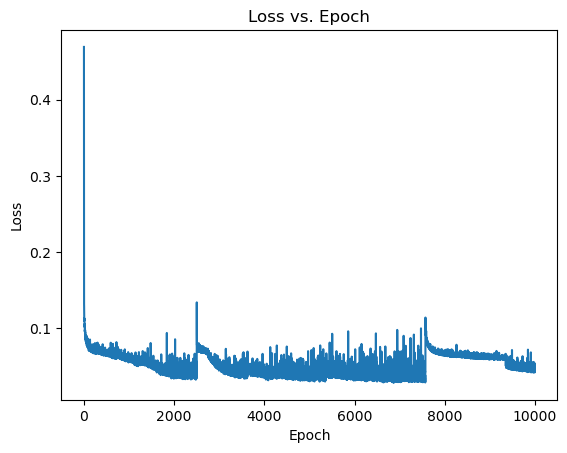

In [10]:
# Plot loss values over epochs
plt.plot(range(epochs), loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.show()

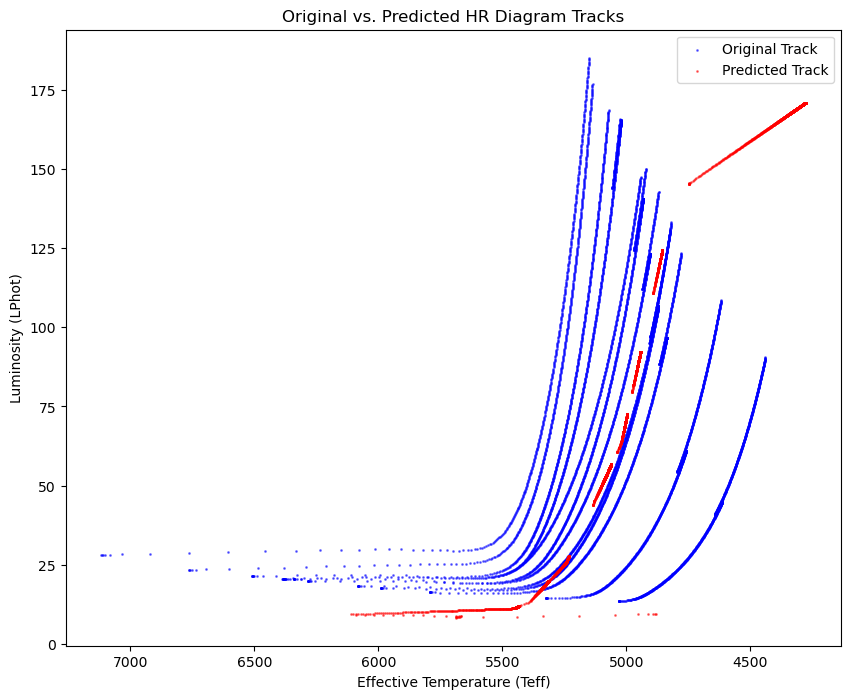

In [11]:

with torch.no_grad():  
    predicted_data_scaled = model(age_data_tensor)

# Scaling data
predicted_data = torch.cat((predicted_data_scaled[:, 0:1], predicted_data_scaled[:, 1:2]), dim=1)
predicted_Teff = teff_scaler.inverse_transform(predicted_data[:, 0].view(-1, 1).numpy()).flatten()
predicted_LPhot = lphot_scaler.inverse_transform(predicted_data[:, 1].view(-1, 1).numpy()).flatten()

# Inverse-transform the true data due to scaling
true_Teff = teff_scaler.inverse_transform(Teff_data_tensor.view(-1, 1).numpy()).flatten()
true_LPhot = lphot_scaler.inverse_transform(LPhot_data_tensor.view(-1, 1).numpy()).flatten()


plt.figure(figsize=(10, 8))


plt.scatter(true_Teff, true_LPhot, color='blue', label='Original Track', alpha=0.5, s=1)
plt.scatter(predicted_Teff, predicted_LPhot, color='red', label='Predicted Track', alpha=0.5, s=1)

# Set labels and title
plt.xlabel("Effective Temperature (Teff)")
plt.ylabel("Luminosity (LPhot)")
plt.title("Original vs. Predicted HR Diagram Tracks")
plt.legend()
plt.gca().invert_xaxis()
plt.show()